# Linear elasticity problem

In this notebook, we solve a linear elasticity problem using FEniCSx.

In the variational form, this problem will have:

a(u,v)=inner(sigma(u),epsilon(u))

L(v)=inner(f*v)*dx+inner(T,v)*dx

(with: T= 0 <--T is the traction vector

sigma(u)= lamda (div(u)I + mu (grad(u)+grad(u)T))

and epsilon(u)=1/2((grad(v)+grad(v)T)) )

## Problem description

We consider a 3D domain representing a beam, fixed at one end and subject to a force at the other end. The goal is to compute the displacement field under the action of the force.

In [ ]:
# Scaled variable
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
L = 1  #beam lenght
W = 0.2 #beam cross section 
mu = 1 
rho = 1 #density of the beam
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [2]:
domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, W])],
                         [20, 6, 6], cell_type=mesh.CellType.hexahedron)
#in questo modo ho creato un dominio 3D (delle seguenti dimensioni: 
#lungo x: L (diviso in 20 celle in questa direzione)
#lungo y: W (diviso in 6 celle in questa direzione)
#lungo z: W (diviso in 6 celle in questa direzione))


V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

### Mesh and function space

We create the mesh and define the function space for the displacement field.

In [3]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)
#questa funzione in pratica restituirà un array di booleani che ci dirà se il boundary che stiamo 
#considerando si trova ad x[0]=0 


#vado a definire le BC 
#per poerlo fare dovrò definire i factes sul boundary 
#ed i dof sul boundary 
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)

u_D = np.array([0, 0, 0], dtype=default_scalar_type) #setto l'homogeneus Dirichelet BC 
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

In [4]:
#noi vogliamo che la traction T sia 0 sui rimanenti boundary 
T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

#poi definisco ds 
ds = ufl.Measure("ds", domain=domain)

In [5]:
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

#Si preferisce usare ufl.nabla_div(u) ed ufl.nabla_grad(u) al posto di ufl.div(u) ed ufl.grad(u)
# se grad di u ha un significato fisico chiaro  

### Boundary conditions

We define the boundary conditions: the left face is fixed (zero displacement), and a force is applied to the right face.

In [6]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

### Solution and visualization

We solve the linear elasticity problem and visualize the displacement field.

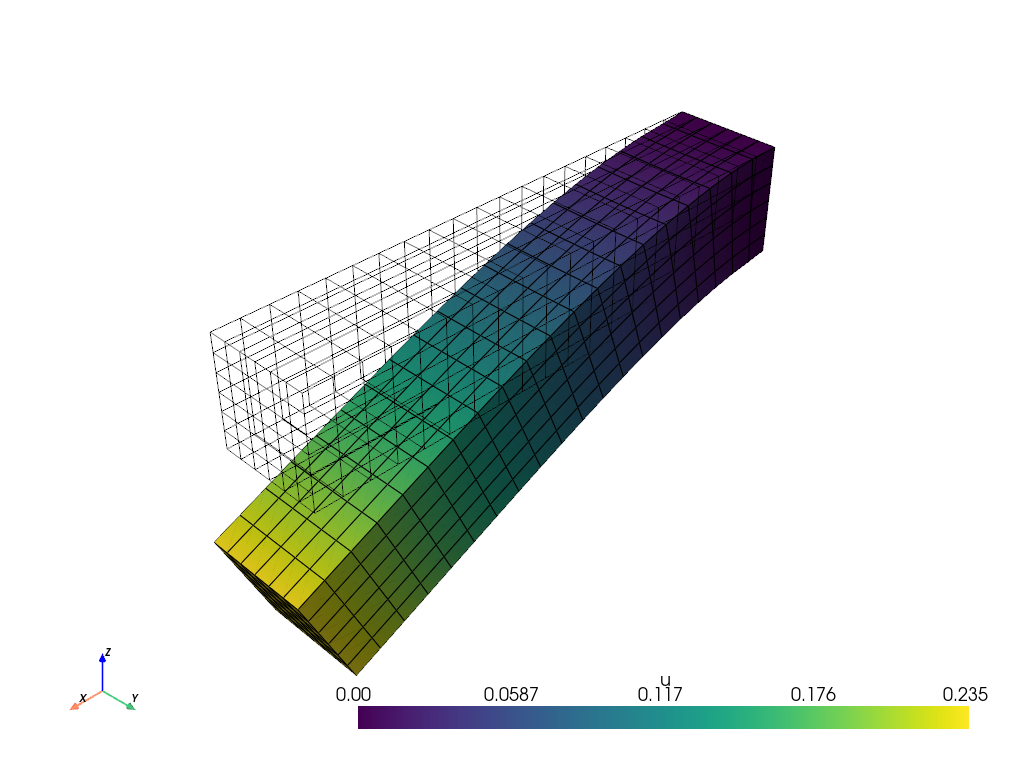

In [7]:
#pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")

In [8]:
with io.XDMFFile(domain.comm, "deformation.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    uh.name = "Deformation"
    xdmf.write_function(uh)